In [2]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import anndata as ad
import pandas as pd
import seaborn as sns

In [3]:
input_dir = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/out/data/feat_414"
output_dir = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/out/plot/feat_414"

folder_suffix = "_414__bs25_temp0.5"
plt_suffix = "_bs25_tau0.5"
X_feat = f"/feat{folder_suffix}/scBaseEncoderFeat_X{plt_suffix}.npy"
Y_feat = f"/feat{folder_suffix}/scBaseEncoderFeat_Y{plt_suffix}.npy"
lin_info =f"/feat{folder_suffix}/train_lineage_info{plt_suffix}.npy"

num_top_lg_toplot = 5

In [4]:
# load the reference clone id and cell  type
adata_subset = ad.read_h5ad('../out/data/Larry_41201_2000.h5ad')
clone_id = adata_subset.obs["clone_id"].to_numpy()
cell_type = adata_subset.obs['Cell type annotation'].to_numpy()  

# Load dataset
data_X = np.load(input_dir+ X_feat)
data_Y = np.load(input_dir+Y_feat)
data = np.concatenate((data_X, data_Y), axis=0)

labels = np.load(input_dir+lin_info)
labels_df = pd.DataFrame({"lineage": list(labels[:,0])+list(labels[:,0]),
                          "cell_id": list(labels[:,1])+list(labels[:,2])})
labels_df['cell_type'] = labels_df['cell_id'].apply(lambda x: cell_type[x])


print("data shape", data.shape)
print("labels_df shape", labels_df.shape)


data shape (35550, 64)
labels_df shape (35550, 3)


#### UMAP Computing

In [5]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

data_X_reduced = embedding[:21540, :]
data_Y_reduced = embedding[21540:, :]

#### Cell-Type coloring across all the cells

/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_2927/1662347486.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(unique_categories))  # 'tab20' has 20 distinct colors


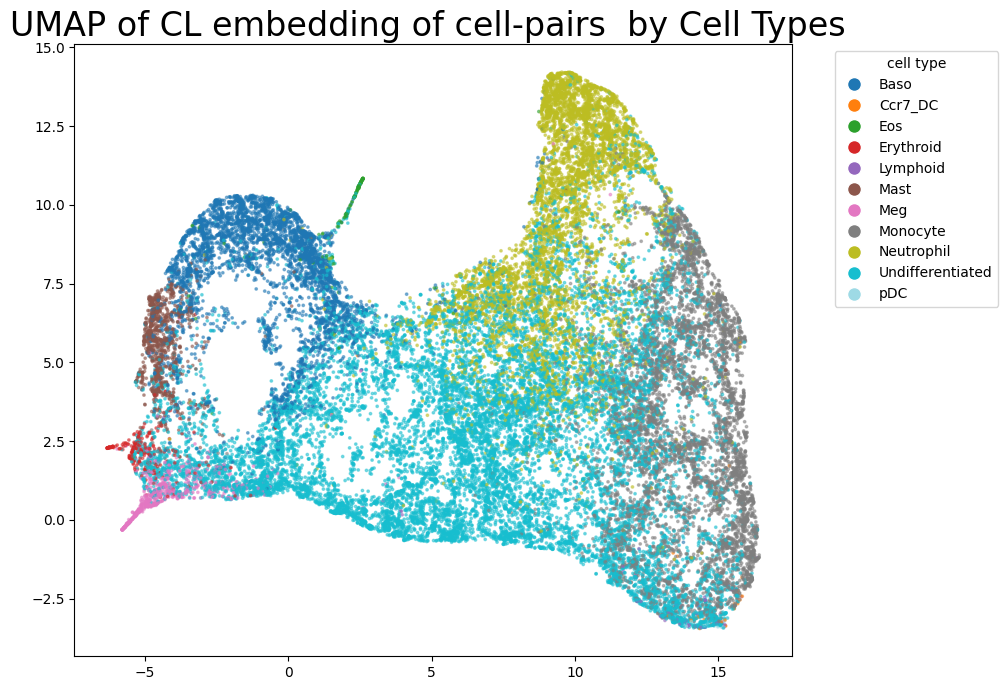

In [6]:
# Map each unique category to a specific color
unique_categories = np.unique(labels_df["cell_type"].to_numpy())
# Select a colormap
colormap = plt.cm.get_cmap('tab20', len(unique_categories))  # 'tab20' has 20 distinct colors
category_to_color = {category: colormap(i) for i, category in enumerate(unique_categories)}

# Convert categories to colors
category_colors = np.array([category_to_color[category] for category in labels_df["cell_type"].to_numpy()])


# Plot the UMAP embedding with dots colored according to 'categories'
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=category_colors, s=3, alpha=0.5)
plt.title('UMAP of CL embedding of cell-pairs  by Cell Types ', fontsize=24)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap(i), markersize=10) for i in range(len(unique_categories))]
plt.legend(handles, unique_categories, title="cell type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig(output_dir+f'umap_CL_embedding_cellType{plt_suffix}.png', dpi=300)
plt.show()

#### Cell-pair with lineage of highest cell number count highlighted

In [7]:
# Assuming 'data_X_reduced', 'data_Y_reduced', 'num_top_lg_toplot', 'input_dir', and 'output_dir' are defined

labels = np.load(input_dir + lin_info)
labels = labels[:,0]  # Assuming the labels are in the first column

unique_labels, counts = np.unique(labels, return_counts=True)

# Prepare the DataFrame
df_X = pd.DataFrame(data_X_reduced, columns=['UMAP1', 'UMAP2'])
df_X['label'] = labels
df_X['type'] = 'X'

df_Y = pd.DataFrame(data_Y_reduced, columns=['UMAP1', 'UMAP2'])
df_Y['label'] = labels
df_Y['type'] = 'Y'

df = pd.concat([df_X, df_Y], ignore_index=True)

# Plotting
# for i in range(1):
i = 4
plt.figure(figsize=(12, 8))

# Recalculate ith_largest_label for each iteration
ith_largest_label = unique_labels[np.argsort(-counts)[i]]

# Plot all points in gray first
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='type', palette={'X': default_color, 'Y': default_color}, style='type', markers={'X': 'o', 'Y': 'o'}, s=1, alpha=0.5)

# Highlight the ith largest label
subset = df[df['label'] == ith_largest_label]
sns.scatterplot(data=subset, x='UMAP1', y='UMAP2', hue='type', palette={'X': 'blue', 'Y': 'red'}, style='type', markers={'X': 'o', 'Y': 'o'}, s=15, alpha=1, legend='full')

# Draw lines for the ith largest label
subset_X = subset[subset['type'] == 'X']
subset_Y = subset[subset['type'] == 'Y'].reset_index()
for j in range(len(subset_X)):
    plt.plot([subset_X.iloc[j]['UMAP1'], subset_Y.iloc[j]['UMAP1']], [subset_X.iloc[j]['UMAP2'], subset_Y.iloc[j]['UMAP2']], color='purple', alpha=0.5)

plt.title(f'UMAP for 21540 Cell-Pairs with #{i+1} Largest Lineage Connected')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label.replace('type_', '') for label in labels]
unique_labels = ['Lineage X', 'Lineage Y']  # Adjust based on your preference
plt.legend(handles[:2], unique_labels, markerscale=5)  # Adjust the slicing based on the actual legend items you need

plt.savefig(output_dir + f'umap_{i}_largest_plot{plt_suffix}.png', dpi=300)
plt.show()


ValueError: Length of values (17775) does not match length of index (21540)

In [ ]:
import seaborn as sns

default_color = "gray"
for i in range(num_top_lg_toplot):

    labels = np.load(input_dir+"/feat_414__bs25_temp0.1/train_lineage_info_bs25_tau0.1.npy")
    labels = labels[:,0]
    unique_labels, counts = np.unique(labels, return_counts=True)
    ith_largest_label = unique_labels[np.argsort(-counts)[i]]

    plt.figure(figsize=(12, 8))

    # Plot all points in gray first to ensure they are at the bottom layer
    for label in np.unique(labels):
        subset_X = data_X_reduced[labels == label]
        subset_Y = data_Y_reduced[labels == label]
        plt.scatter(subset_X[:, 0], subset_X[:, 1], s=1, color=default_color, alpha=0.5)
        plt.scatter(subset_Y[:, 0], subset_Y[:, 1], s=1, color=default_color, alpha=0.5)

    # Now, plot the points for the second largest label in distinct colors
    for label in np.unique(labels):
        if label == ith_largest_label:
            subset_X = data_X_reduced[labels == label]
            subset_Y = data_Y_reduced[labels == label]
            plt.scatter(subset_X[:, 0], subset_X[:, 1], s=15, color="blue", label=f"Lineage {label} (X)")
            plt.scatter(subset_Y[:, 0], subset_Y[:, 1], s=15, color="red", label=f"Lineage {label} (Y)")
            
            # Draw lines connecting points with the same position for the second largest label
            for j in range(len(subset_X)):
                plt.plot([subset_X[j, 0], subset_Y[j, 0]], [subset_X[j, 1], subset_Y[j, 1]], color='purple', alpha=0.5)

    plt.title(f'UMAP for 21540 Cell-Pairs with # {i+1} Largest Lineage Connected')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')

    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = list(set(labels))
    unique_handles = [handles[labels.index(l)] for l in unique_labels]
    plt.legend(unique_handles, unique_labels, markerscale=5)

    plt.savefig(output_dir+f'umap_{i}_largest_plot{plt_suffix}', dpi=300)
    plt.show()


#### Cell-pair with lineage of highest cell number count highlighted regarding cell type

In [8]:
# Assuming 'embedding', 'labels_df', 'input_dir', 'num_top_lg_toplot', and 'output_dir' are defined

default_color = 'gray'

labels = np.load(input_dir + lin_info)
labels = np.array(list(labels[:, 0])+list(labels[:, 0]))
categories = labels_df["cell_type"].to_numpy()

unique_labels, counts = np.unique(labels, return_counts=True)
top_lineages = unique_labels[np.argsort(-counts)[:num_top_lg_toplot]]

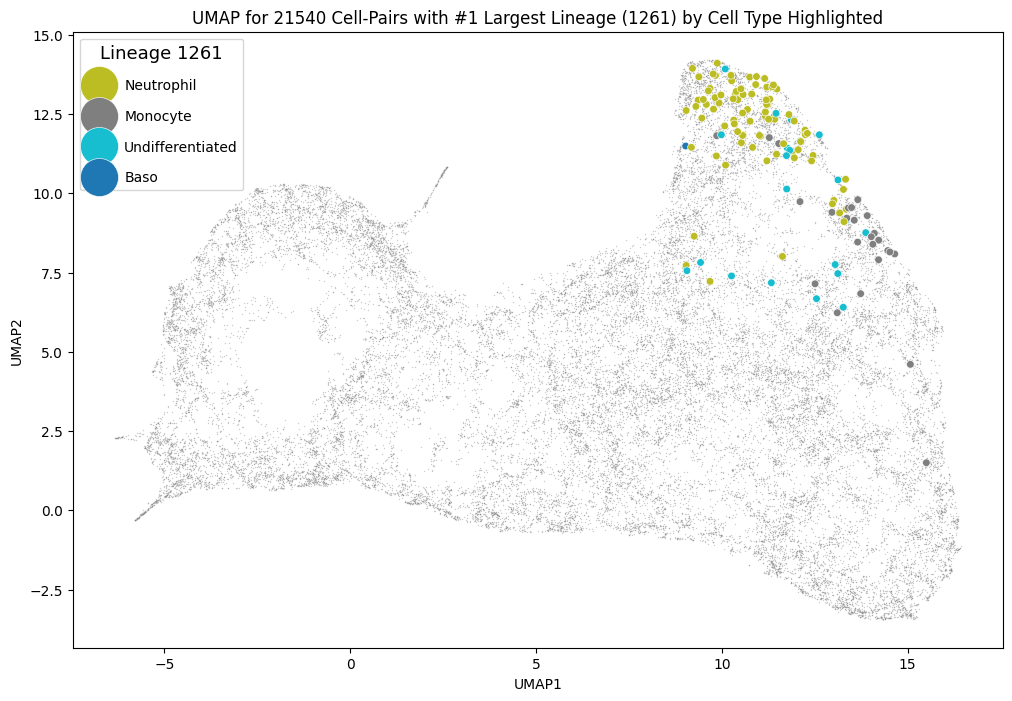

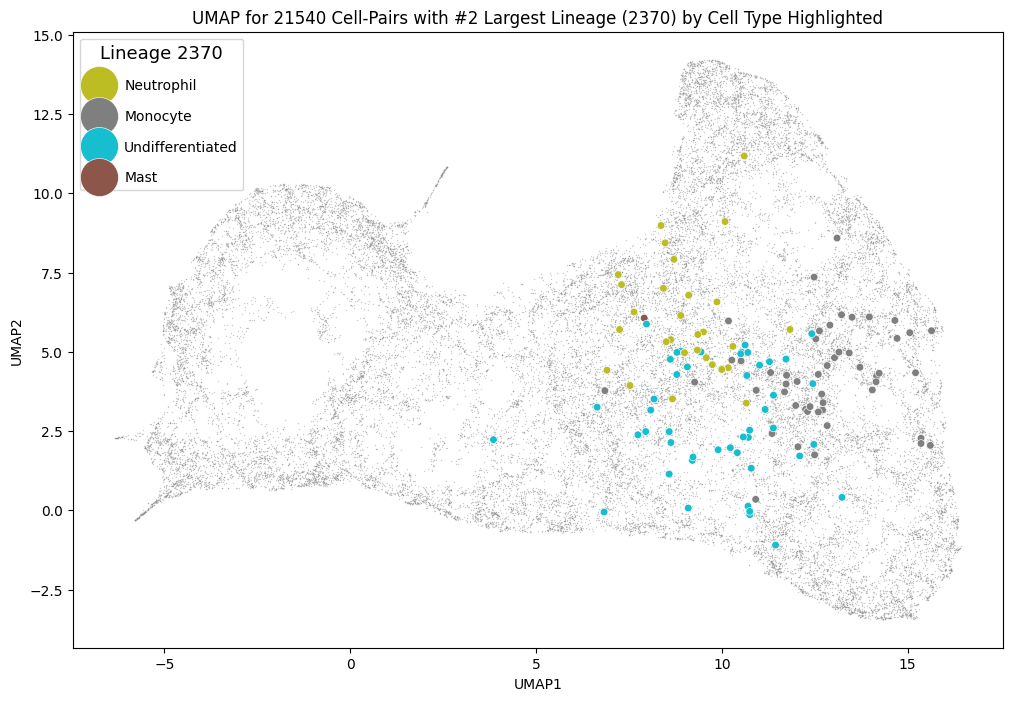

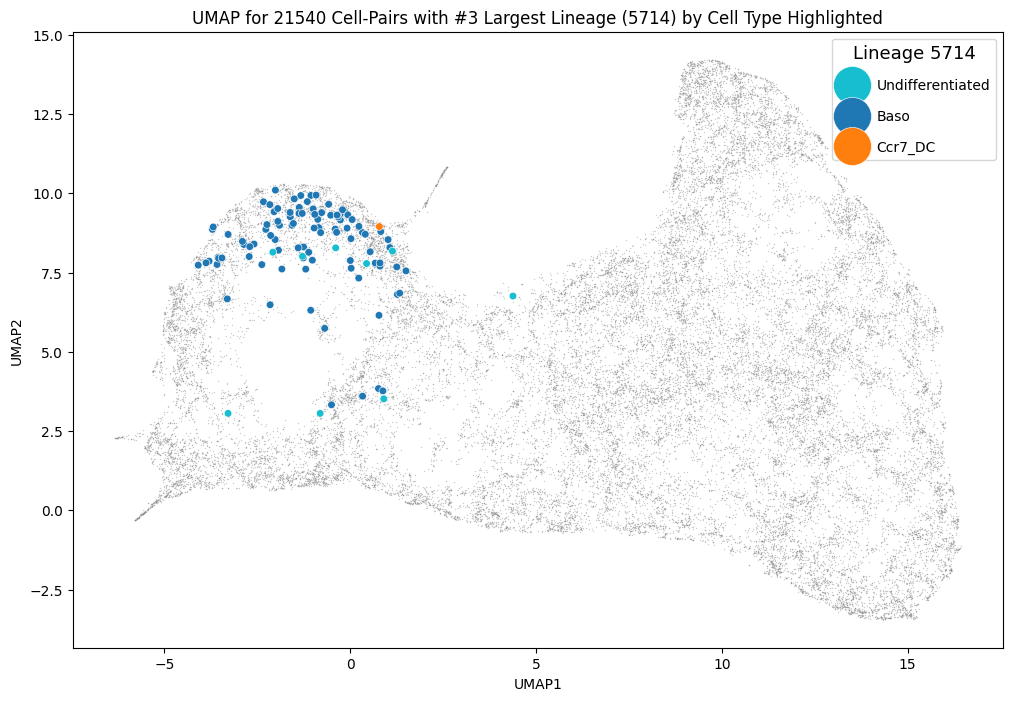

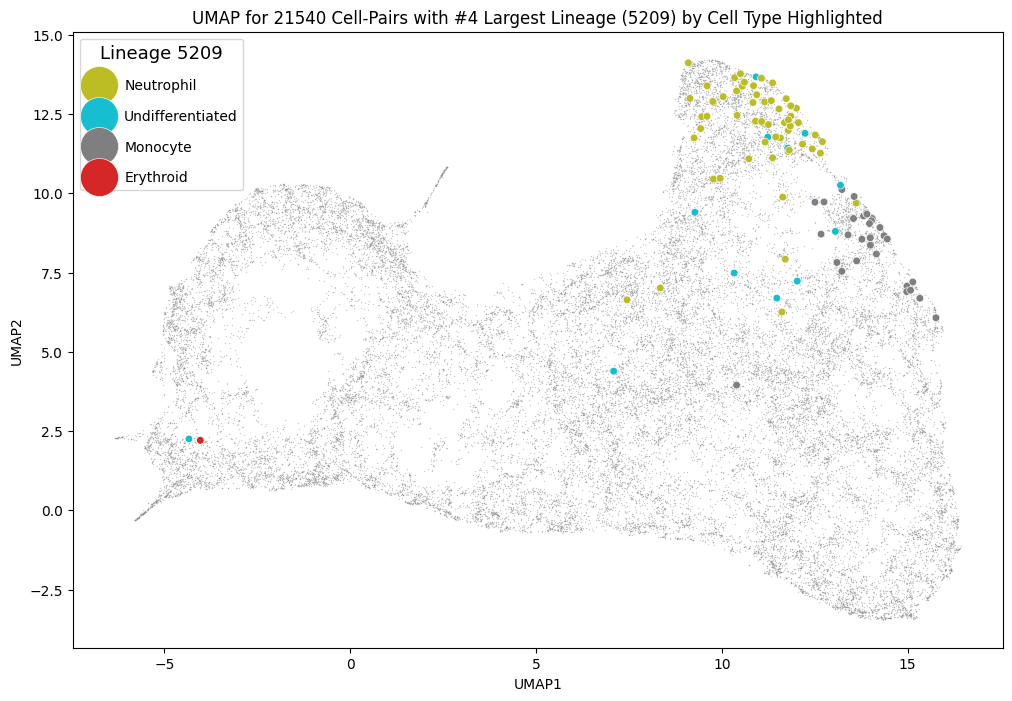

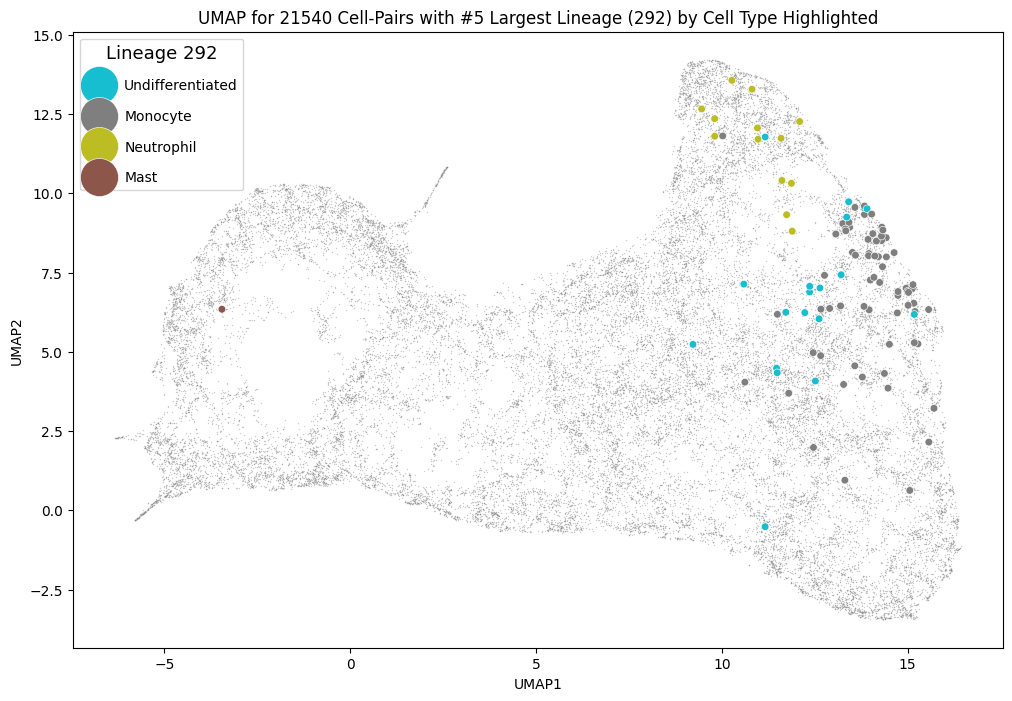

In [9]:
# Assuming 'embedding', 'labels', 'categories', and 'category_to_color' are defined
# Convert data to DataFrame for easier manipulation with Seaborn
df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df['label'] = labels
df['category'] = categories  # Ensure this is aligned with your 'labels'

# Define your color palette, mapping from category to color
palette = {category: category_to_color[category] for category in np.unique(categories)}

# Plotting
for i, lineage in enumerate(top_lineages):
    plt.figure(figsize=(12, 8))
    # Plot all points with a default color
    sns.scatterplot(data=df[~df['label'].isin([lineage])], x='UMAP1', y='UMAP2', color=default_color, s=1, alpha=0.4)

    # Highlight the selected lineage
    lineage_df = df[df['label'] == lineage]
    sns.scatterplot(data=lineage_df, x='UMAP1', y='UMAP2', hue='category', palette=palette, s=30, alpha=1, legend='full')

    plt.title(f'UMAP for 21540 Cell-Pairs with #{i+1} Largest Lineage ({lineage}) by Cell Type Highlighted')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title=f'Lineage {lineage}', title_fontsize='13', labelspacing=1.2, markerscale=5)
    plt.savefig(output_dir + f'umap_{i}_largest_plot_by_CellType{plt_suffix}.png', dpi=300)
    plt.show()
